# Demo - Run Expectancy

This demo explores the concept of run expectancy and the _Run Expectancy Matrix_, an empirically driven measurement of how many runs we should expect to score in a given out/baserunner state.  We use run expectancy to explore basic baseball strategies like bunting and stealing.

In [ ]:
%run ../../utils/notebook_setup.py

In [ ]:
from datascience import Table, are
import numpy as np

# custom functions that will help do some simple tasks
from datascience_utils import *
from datascience_stats import *
from datascience_topic import fast_run_expectancy

## 1. Retrosheet Play-by-Play Data

Retrosheet data (http://www.retrosheet.org/) contains play-by-play event logs, a very raw form labeling all the events in a baseball game. Lucky for us, the software program Chadwick (found here: http://chadwick.sourceforge.net/doc/index.html) was created to handle a lot of the messy work to compiled the data into a useable form.  Chadwick converts the raw logs into CSV which is what we use here.  Also, Chadwick computes some pretty important quantities that we make use of.

Note: This notebook uses data from 2001.  We could have used more recent data but Barry Bonds is a baseball god so part of this notebook is an excuse to revel in his statistical absurdity.

### Loading the Data
For our purposes, like computing the Run Expectancy Matrix, we only need a few of the columns available.  The relevant columns are:
+ EVENT_ID - An ID for the event in the dataset
+ INN_CT - Inning number
+ BAT_HOME_ID - A flag indicating if the home team is batting
+ EVENT_CD - A code for what happened in the event
+ OUTS_CT - Number of outs
+ BAT_LINEUP_ID - Place in the batting order.  1 through 9.
+ BAT_EVENT_FL - A T/F flag as to whether the play-by-play event corresponds to a plate appearance (T) or some other type of event (F).
+ START_BASES_CD - An integer code representing the state of the runners, eg. runner on 2nd
+ END_BASES_CD - An integer code representing the state of the runners AFTER the event ends.
+ EVENT_OUTS_CT - Number of outs recorded on this event
+ EVENT_RUNS_CT - Number of runs scored on this event
+ FATE_RUNS_CT - Number of runs scored AFTER this event
+ INN_NEW_FL - A flag indicating if the PA is the start of a new half-inning

In [ ]:
col_names = [
    'INN_CT', 'BAT_HOME_ID', 'EVENT_CD', 'OUTS_CT', 'BAT_ID', 
    'BAT_LINEUP_ID', 'BAT_EVENT_FL', 'START_BASES_CD', 'END_BASES_CD', 
    'EVENT_OUTS_CT', 'EVENT_RUNS_CT', 'FATE_RUNS_CT', 'INN_NEW_FL']

retro = Table.read_table(
    'retrosheet_events-2017.csv.gz', sep=',', usecols=col_names)

new_col_names = [
    'Inning', 'Half-Inning', 'Event_Type', 'Outs', 'Batter_ID', 
    'Lineup_Order', 'PA_Flag', 'Start_Bases', 'End_Bases', 'Event_Outs', 
    'Event_Runs', 'Future_Runs', 'New_Inning']
retro.relabel(col_names, new_col_names)

retro.show(10)

### Data Processing

There are a few things we need to do to make the dataset a little easier to use.  

First, three of the columns use integer codes to succinctly summarize their information.  Baserunner situations and event types are given by these integer codes.  For interpretation, this isn't helpful at all.  So we want to convert the integer codes into recognizable strings.  This information is available from http://www.retrosheet.org/.

In [ ]:
base_runner_codes = {
    0: "None on",  # No one on
    1: "1st",  # runner on 1st
    2: "2nd",  # runner on 2nd
    3: "1st and 2nd",  # runners on 1st & 2nd
    4: "3rd",  # runner on 3rd
    5: "1st and 3rd",  # runners on 1st & 3rd
    6: "2nd and 3rd",  # runners on 2nd & 3rd
    7: "Bases Loaded"  # bases loaded
}
# Replace the numeric code with a string code
retro['Start_Bases'] = replace(retro, 'Start_Bases', base_runner_codes)
retro['End_Bases'] = replace(retro, 'End_Bases', base_runner_codes)

In [ ]:
event_codes = {
    0: 'Unknown',
    1: 'None',
    2: 'Generic out',
    3: 'K',  # Strikeout
    4: 'SB',  # Stolen Base
    5: 'Defensive indifference',
    6: 'CS',  # Caught stealing
    7: 'Pickoff error',
    8: 'Pickoff',
    9: 'Wild pitch',
    10: 'Passed ball',
    11: 'Balk',
    12: 'Other advance/out advancing',
    13: 'Foul error',
    14: 'BB',  # Walk
    15: 'IBB',  # Intentional walk
    16: 'HBP',  # Hit by pitch
    17: 'Interference',
    18: 'RBOE',  # Reached base on error
    19: 'FC',  # Fielder's choice
    20: '1B',  # Single
    21: '2B',  # Double
    22: '3B',  # Triple
    23: 'HR',  # Home run
    24: 'Missing play',
}

# Replace numeric code with string
retro['Event_Type'] = replace(retro, 'Event_Type', event_codes)

Second, the play-by-play data contains entries that are not plate appearances.  One example is balks.  We want to drop these entries because they are not relevant to the question we are trying to answer.  

In [ ]:
retro = retro.where('PA_Flag', value_or_predicate="T")

### Visualizations

We can get an idea of what we're dealing with over a season of baseball data by looking at a few different visualizations.

In [ ]:
retro.group_barh('Start_Bases', width=8)

In [ ]:
retro.group_barh('Event_Type', width=8)

In [ ]:
retro.group_barh('Event_Runs', width=8)

## 2. Runs in Remainder of Inning

In order to compute the Run Expectancy Matrix, we need to just add `Future_Runs` and `Event_Runs`.  

In [ ]:
retro['Runs_ROI'] = retro['Future_Runs'] + retro['Event_Runs']

In [ ]:
retro.where('New_Inning', value_or_predicate="T").\
    select("Runs_ROI").\
    hist()

In [ ]:
retro.where('New_Inning', value_or_predicate="T").\
    group("Runs_ROI").\
    show(15)

In [ ]:
tmp = retro.where('New_Inning', value_or_predicate="T").\
    group('Inning', collect=np.mean).\
    select('Inning', 'Runs_ROI mean')
    
tmp.bar('Inning', 'Runs_ROI mean', width=13)

## 3. Run Expectancy Matrix

The Run Expectancy Matrix is computed by grouping by `Outs` and `Bases` and computing an average.  For each out and baserunner combination, this collects all plate appearances in our dataset and the runs scored in the remainder of the inning from that plate appearance and after.  We are left with the 24 values that comprise the Run Expectancy Matrix.

First, though, we need to drop all data from the ninth inning or later.  This is because we want data that represents the regular course of play.  We hypothesize these innings feature end-game strategy and thus the events violate some of our assumptions about the regular strategic play, or even are truncated due to walk-off events.

In [ ]:
retro_pre9 = retro.where('Inning', are.below(9))

In [ ]:
run_expectancy = retro_pre9.select('Outs', 'Start_Bases', 'Runs_ROI').\
    group(['Outs', 'Start_Bases'], collect=np.mean)
run_expectancy.relabel('Runs_ROI mean', 'RE')
run_expectancy

In [ ]:
run_expectancy.pivot('Outs', 'Start_Bases', values='RE', collect=np.sum).\
    sort('0')

### Run Expectancy and Understanding Baseball

#### Average RE Value by Game State

In [ ]:
run_expectancy.select('Start_Bases', 'RE').\
    group('Start_Bases', collect=np.mean).\
    sort('RE mean')

#### Cost of Making an Out by Game State

In [ ]:
bases = run_expectancy.where('Outs', 0)['Start_Bases']
zero_outs = run_expectancy.where('Outs', 0)['RE']
one_out = run_expectancy.where('Outs', 1)['RE']
two_out = run_expectancy.where('Outs', 2)['RE']


out_costs = Table().with_columns(
    'Start_Bases', bases,
    '0 to 1',  one_out - zero_outs,
    '1 to 2',  two_out - one_out
)
out_costs

##### Cost of an Out When Third Base is Open

In [ ]:
is_third_base_open = are.contained_in(['None on', '1st', '2nd', '1st and 2nd'])
out_costs.where('Start_Bases', is_third_base_open)

##### Cost of an Out When a Runner is on Third Base

In [ ]:
is_runner_on_third = are.contained_in(['3rd', '1st and 3rd', '2nd and 3rd', 'Bases Loaded'])
out_costs.where('Start_Bases', is_runner_on_third)

### Making the First or Third Out at Third Base

In [ ]:
def get_matrix_value(table, outs, base):
    for o, b, v in table.to_array():
        if outs == o and base == b:
            return v

#### Making First Out

In [ ]:
re_2nd_0out = get_matrix_value(run_expectancy, 0, '2nd')
re_3rd_0out = get_matrix_value(run_expectancy, 0, '3rd')
re_3rd_1out = get_matrix_value(run_expectancy, 1, '3rd')

re_2nd_0out, re_3rd_0out, re_3rd_1out

In [ ]:
re_1st2nd_0out = get_matrix_value(run_expectancy, 0, '1st and 2nd')
re_1st3rd_0out = get_matrix_value(run_expectancy, 0, '1st and 3rd')
re_1st3rd_1out = get_matrix_value(run_expectancy, 1, '1st and 3rd')

re_1st2nd_0out, re_1st3rd_0out, re_1st3rd_1out

#### Making Third Out

In [ ]:
re_2nd_2out = get_matrix_value(run_expectancy, 2, '2nd')
re_3rd_2out = get_matrix_value(run_expectancy, 2, '3rd')
re_3rd_3out = 0

re_2nd_2out, re_3rd_2out, re_3rd_3out

In [ ]:
re_1st2nd_2out = get_matrix_value(run_expectancy, 2, '1st and 2nd')
re_1st3rd_2out = get_matrix_value(run_expectancy, 2, '1st and 3rd')
re_1st3rd_3out = 0

re_1st2nd_2out, re_1st3rd_2out, re_1st3rd_3out

_Questions_
1. What does the Run Expectancy Matrix describe about the nature of baseball?  
2. What can you observe about the difference between having a runner on second base vs third base (consider 2nd vs 3rd and 1st and 2nd vs 1st and 3rd)?  
3. How do things change with 2 outs?
4. What does run expectancy tell us generally about outs?  That is, how valuable is one extra base compared to an out?

## 4. RE24

The RE24 run production values for each plate appearance is computed as
$$
    \mathit{RE24} = \text{Run Expectancy}_{\text{Next}} - \text{Run Expectancy}_{\text{Current}} + \text{Runs Scored}
$$

In [ ]:
# # NOTE: THIS CELL IS SLOW.
# # It's easier to understand what the calculation is with this block of code but
# # after that, you might as well run the next cell.

# # Iterate through each PA computing run expectancy
# # We need each PA's start outs, start bases, end outs, and end bases
# next_outs = retro['Outs'] + retro['Event_Outs']
# outs_and_bases = zip(
#     retro['Outs'],
#     retro['Start_Bases'],
#     next_outs,
#     retro['End_Bases']
# )

# # We build lists of current and next RE
# run_exp = []
# run_exp_next = []
# for out, start_base, next_out, end_base in outs_and_bases:
#     # Get current RE
#     start_val = get_matrix_value(run_expectancy, outs, start_base)
#     run_exp.append(start_val)
    
#     # Get next RE.  If PA ends inning, next RE is 0
#     if next_out < 3:
#         end_val = get_matrix_value(run_expectancy, next_out, end_base)
#     else:
#         end_val = 0
#     run_exp_next.append(end_val)
    
# # Convert lists to numpy arrays
# retro['Run_Expectancy'] = np.array(run_exp)
# retro['Run_Expectancy_Next'] = np.array(run_exp_next)

In [ ]:
# This only takes about a second or two
retro = fast_run_expectancy(retro, run_expectancy)

In [ ]:
view_cols = ['Batter_ID', 'Lineup_Order', 'Inning', 'Outs', 'Event_Type',
             'Start_Bases', 'End_Bases', 'Event_Runs', 'Run_Expectancy',
             'Run_Expectancy_Next']
retro.select(view_cols).show(5)

### Compute RE24
Now its easy to compute the RE24 values using the fields we have computed.

In [ ]:
retro['RE24'] = retro['Run_Expectancy_Next'] - \
    retro['Run_Expectancy'] + retro['Event_Runs']

#### Example

Here are the first 10 rows from the Retrosheet table showing the first inning plus a bit of the second inning of the first game between the Angels and the Mariners.

In [ ]:
view_cols = ['Batter_ID', 'Lineup_Order', 'Inning', 'Outs', 'Event_Type',
             'Start_Bases', 'End_Bases', 'Event_Runs', 'Run_Expectancy',
             'Run_Expectancy_Next', 'RE24']
retro.select(view_cols).show(10)

#### Grand Slams

Below are three grand slams hit by Brandon Belt, Manny Machado, and Aaron Judge with different out situations.

First, notice how the high run expectancy at the beginning of the at-bat leads to a reduced or "discounted" RE24 value that does not equal 4.

Second, notice how the circumstances of the outs lead to receiving different values for the grand slam.

In [ ]:
retro.select(view_cols).take(136255)

In [ ]:
retro.select(view_cols).take(23031)

In [ ]:
retro.select(view_cols).take(107066)

#### Mookie Betts Going 1st to 3rd
A good baserunner like Mookie Betts (11th in SB with 26) that can get from 1st to 3rd on a hit easier can make the next hitter look better.

The following two pairs of events have Mookie reaching 1st with no outs.  Compare the RE24 values of these two outcomes for the subsequent batters.  The events are identical except for Mookie going to 3rd instead of 2nd on the single with Dustin Pedroia as the next hitter.  While we know little about the nature of the single that was hit, this shows a variation in values of RE24 for seemingly equal events.

In [ ]:
retro.take([27834, 27835])

In [ ]:
retro.take([26962, 26963])

### Batter RE24

We can group on `Batter_ID` and compute the Total RE24 for each batter.  We do this by just summing.

We don't have much context for how this statistic should behave since we only have one year and only view the top 10.  We could dive into the statistic more on Baseball Reference or FanGraphs.  For context, Barry Bonds' 2001, 2002, and 2004 seasons were absolutely obscene when it comes to offense and run production by any and all metrics.  Here are the RE24 values for 2001: 

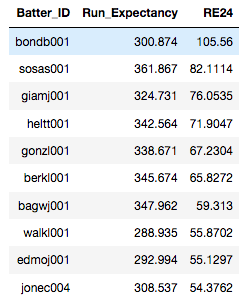

In [ ]:
# Collect totals by batter
batter_data = retro.select('Batter_ID', 'Run_Expectancy', 'RE24').\
    group('Batter_ID', collect=sum)

# Sort and display the top 10
batter_data.sort('RE24 sum', descending=True).\
    show(10)

In [ ]:
batter_data.scatter('Run_Expectancy sum', select='RE24 sum')